In [13]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import spearmanr

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, make_scorer

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH_RAW = '../data/raw_data/'
PATH_INTER = '../data/intermediate/'
PATH_DATA = '../data/data/'
PATH_MODELS = '../../models/'
PATH_IMAGES = '../assets/images/'

In [3]:
train = pd.read_csv(PATH_DATA + "CRC_2880_train.csv")
val = pd.read_csv(PATH_DATA + "CRC_320_val.csv")
test_CRC = pd.read_csv(PATH_DATA + "CRC_800_test.csv")

In [4]:
train.loc[train['read_score'] < 0.0, 'read_score'] = 0.0
train.loc[train['read_score'] > 100.0, 'read_score'] = 100.0

In [5]:
def plot_value_counts(df, col):
    """Plot value counts of a column"""
        
    plt.figure(figsize = (12, 5))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 1.5)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [6]:
correl = train.corr()

correl['tag'].sort_values(ascending=False)

tag                1.000000
bin_tag            0.866370
num_positives      0.461502
num_tokens         0.389669
num_unk            0.382112
num_char           0.381596
sentiment          0.366212
num_punct          0.357476
num_discourse      0.345012
num_modals         0.314870
num_negatives      0.272517
named_entities     0.178657
num_upper          0.070443
avg_word_length   -0.060761
read_score        -0.290127
Name: tag, dtype: float64

In [7]:
X_train, y_train, y_bin_train = train.drop(['tag', 'bin_tag'], axis=1), train['tag'].copy(), train['bin_tag'].copy()
X_val, y_val, y_bin_val = val.drop(['tag', 'bin_tag'], axis=1), val['tag'].copy(), val['bin_tag'].copy()
X_test_CRC, y_test_CRC, y_bin_test_CRC = test_CRC.drop(['tag', 'bin_tag'], axis=1), test_CRC['tag'].copy(), test_CRC['bin_tag'].copy()

In [8]:
numeric_features = list(X_train[['read_score', 'sentiment', 'num_tokens',
                                 'num_char', 'num_upper', 'named_entities',
                                 'num_positives', 'num_negatives', 'num_unk',
                                 'num_punct', 'num_discourse', 'num_modals',
                                 'avg_word_length']])

text_features = list(X_train[['text_review', 'text_pos', 'lemmas']])

In [9]:
trans = ColumnTransformer(transformers=[
            ('review', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,1)), 'text_review'),
            ('pos', TfidfVectorizer(encoding='utf-8', ngram_range=(1,1)), 'text_pos'),
            ('lemma', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,1)), 'lemmas'),
            ('num_attr', StandardScaler(), numeric_features),
            ],
                         #remainder='passthrough'
                         )

pipeline = Pipeline([
               ('union', trans),
               #('clf', RandomForestClassifier(n_estimators=100, random_state=10, 
                              #n_jobs = -1))
])

In [247]:
# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'weighted')

clf = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)

cv_score = cross_val_score(clf, X_train_new, y_train, cv = 10, scoring = scorer)

In [248]:
print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.6397 with std = 0.0234


## Model comparison

In [10]:
X_train_new = pipeline.fit_transform(X_train)

In [20]:
X_val_new = pipeline.fit_transform(X_val)

In [12]:
X_test_CRC_new = pipeline.transform(X_test_CRC)

In [261]:
# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

In [262]:
model_results = cv_model(X_train_new, y_train, LinearSVC(), 
                         'LSVC', model_results)

10 Fold CV Score: 0.57018 with std: 0.02677


In [263]:
model_results = cv_model(X_train_new, y_train, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.60122 with std: 0.02769


In [264]:
model_results = cv_model(X_train_new, y_train, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.6368 with std: 0.02733


In [265]:
model_results = cv_model(X_train_new, y_train,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results)

10 Fold CV Score: 0.63967 with std: 0.0234


In [266]:
model_results = cv_model(X_train_new, y_train,
                          GradientBoostingClassifier(learning_rate=0.3, max_depth=10, random_state=10),
                              'RF', model_results)

10 Fold CV Score: 0.65578 with std: 0.01714


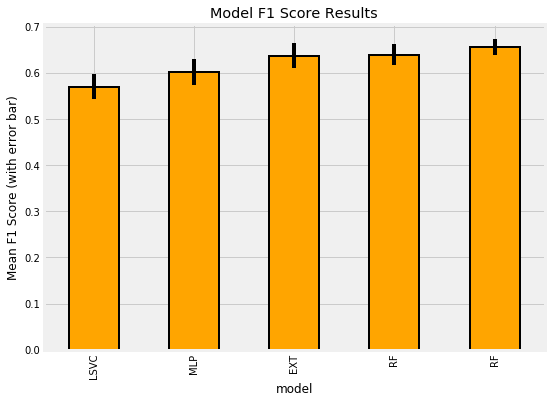

In [267]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

## Feature selection

In [271]:
estimator = RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)

selector = RFECV(estimator, step=10, cv=3, scoring=scorer, n_jobs=-1)

selector.fit(X_train_new, y_train)

KeyboardInterrupt: 

In [ ]:
plt.plot(selector.grid_scores_);

plt.xlabel('Number of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores');
selector.n_features_

In [ ]:
X_train_selected = selector.transform(X_train_new)
X_test_selected = selector.transform(X_test_new)

## Gradient Boosting

In [18]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

In [23]:
params = {'boosting_type': 'dart', 
          'colsample_bytree': 0.88, 
          'learning_rate': 0.028, 
          'min_child_samples': 10, 
          'num_leaves': 36, 'reg_alpha': 0.76, 
          'reg_lambda': 0.43, 
          'subsample_for_bin': 40000, 
          'subsample': 0.54, 
          'class_weight': 'balanced'}

model = lgb.LGBMClassifier(**params, objective='multiclass', 
                               n_jobs=-1, n_estimators=10000,
                               random_state=10)

strkfold = StratifiedKFold(n_splits=5, shuffle=True)

# Convert to arrays for indexing
features = np.array(X_train_new)
test_features = np.array(X_val_new)
labels = np.array(y_train).reshape((-1))

valid_scores = []

# Train with early stopping
model.fit(features, labels, early_stopping_rounds=100, 
          eval_metric=macro_f1_score,
          eval_set=[(X_train_new, y_train), (X_val_new, y_val)],
          eval_names=['train', 'val'],
          verbose=200)

ValueError: setting an array element with a sequence.